In [72]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scienceplots
import networkx as nx
from tqdm import tqdm
%matplotlib inline

# Extend PATH Variable
import sys
sys.path.append("src/")

# NanoNets Simulation Tool
import nanonets
import nanonets_utils

# Plot Colors
blue_color  = '#348ABD'
red_color   = '#A60628'

In [126]:
q   = np.cumsum(np.random.uniform(-20,30,100))
dt  = 2
t   = np.cumsum(np.repeat(2,100))

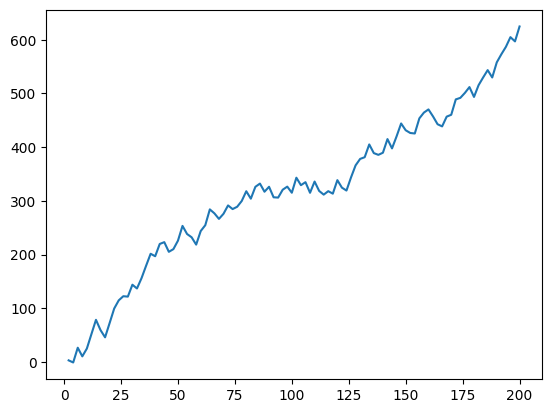

In [127]:
plt.plot(t, q)

In [128]:
I = (q[1:] - q[:-1])/dt

In [129]:
I2 = (q[:-3] - 8*q[1:-2] + 8*q[2:-1] - q[3:])/12*dt

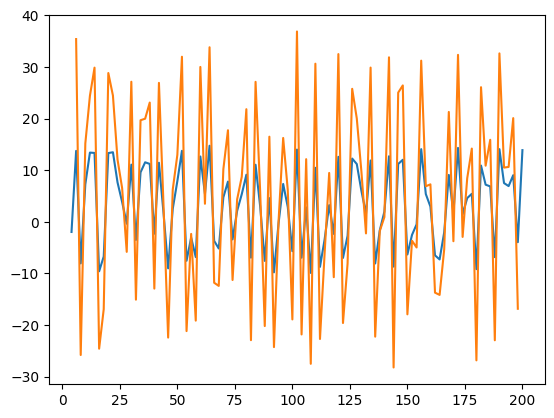

In [138]:
plt.plot(t[1:], I)
plt.plot(t[2:-1], I2)


In [79]:
I2 = []
for i in range(2,len(dq)-2):
    I2.append((-dq[i+2] + 8*dq[i+1] - 8*dq[i-1] + dq[i-2])/12*dt)

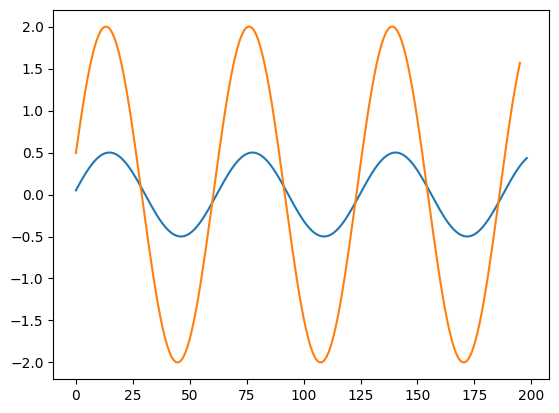

In [80]:
plt.plot(I)
plt.plot(I2)

In [32]:
I = dq/dt
I

array([25., 10., 15.,  5., 30., 35., 15., 10.,  5., 50.])

In [30]:
dqs

array([ 50,  70, 100, 110, 170, 240, 270, 290, 300, 400])

In [2]:
nanonets_utils.store_average_time_currents("scripts/2_funding_period/WP2/freq_double/uniform/data", 7, 7, 1, 3, 10, 10)

In [4]:
# Example: Cubic Network
network_topology = "cubic"

# Network Parameter
topology_parameter = {
    "Nx"    : 7,
    "Ny"    : 7,
    "Nz"    : 1,
    "e_pos" : [[3,0,0],[0,3,0],[6,6,0]]
}

# Nanoparticle Parameter
np_info = {
    "eps_r"         : 2.6,
    "eps_s"         : 3.9,
    "mean_radius"   : 10.0,
    "std_radius"    : 0.0,
    "np_distance"   : 1.0
}

# Nanoparticle Resistances
res_info = {
    "mean_R"    : 25.0,
    "std_R"     : 0.0    
}

# Save Folder
folder  = ""

# Network Class Object
np_network_cubic = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter, folder=folder, np_info=np_info, res_info=res_info)

(<Figure size 350x262.5 with 1 Axes>, <AxesSubplot: >)

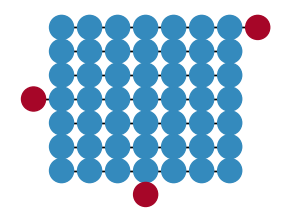

In [4]:
nanonets_utils.display_network(np_network_cubic)

In [5]:
pos = np_network_cubic.pos

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

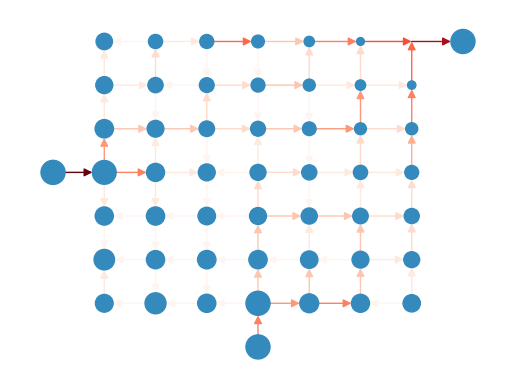

In [6]:
nanonets_utils.display_network_currents("scripts/2_funding_period/WP2/freq_double/uniform/data/net_currents_Nx=7_Ny=7_Nz=1_Ne=3.csv",
                        row=1, N_electrodes=3, arrow_scale=3, charge_landscape=True, node_size=300, pos=pos)

In [7]:
def display_network_currents(path : str, row, N_electrodes : int, charge_landscape=False, pos=None, fig=None, ax=None,
                             arrow_scale=2, arrowsize=12, node_size=300, blue_color='#348ABD', red_color='#A60628', position_by_currents=False):

    if fig == None:
        fig = plt.figure()
    if ax == None:
        ax = fig.add_subplot()
        
    ax.axis('off')

    df          = pd.read_csv(path)
    values      = df.loc[row,:].values
    junctions   = np.array([eval(val) for val in df.columns])

    values_new      = []
    junctions_new   = []

    for n1, junction in enumerate(junctions):

        i       = junction[0]
        j       = junction[1]
        val1    = values[n1]
        n2      = np.where(((junctions[:,0]==j) & (junctions[:,1]==i)))[0][0]

        if n2 > n1:
            
            val2  = values[n2]
            values_new.append(np.abs(val2-val1))
            
            if val1 > val2:
                junctions_new.append([i-N_electrodes,j-N_electrodes])
            else:
                junctions_new.append([j-N_electrodes,i-N_electrodes])

    values_new = arrow_scale*(values_new - np.min(values_new))/(np.max(values_new) - np.min(values_new))

    G = nx.DiGraph()
    G.add_nodes_from(np.arange(np.min(junctions)-N_electrodes, np.max(junctions)+1-N_electrodes))

    if charge_landscape:
        states  = pd.read_csv(path.replace("net_currents", "mean_state")).loc[row,:].values
        colors  = np.repeat(blue_color, len(G.nodes)-N_electrodes)
        colors[np.where(states < 0)] = red_color
        colors  = np.insert(colors, 0, np.repeat(blue_color, N_electrodes))
        states  = np.abs(states)
        states  = node_size*(states - np.min(states))/(np.max(states)-np.min(states))
        states  = np.insert(states, 0, np.repeat(node_size, N_electrodes))
    else:
        states  = np.repeat(node_size, len(G.nodes))

    for val, junction in zip(values_new, junctions_new):

        G.add_edge(junction[0], junction[1], width=val)

    widths = [G[u][v]['width'] for u, v in G.edges]

    if pos == None:
        if position_by_currents:
            pos = nx.kamada_kawai_layout(G=G, weight='width')
        else:
            pos = nx.kamada_kawai_layout(G=G)
    else:
        keys        = [-i for i in range(1, N_electrodes+1)]
        key_vals    = [pos[i] for i in keys]
        new_keys    = keys[::-1]

        for key in keys:
            pos.pop(key)
        
        for i, key in enumerate(new_keys):
            pos[key] = key_vals[i]

    nx.draw(G=G, pos=pos, ax=ax, edge_color=widths, arrowsize=arrowsize, node_size=states, edge_cmap=plt.cm.Reds, node_color=colors)

    return fig, ax

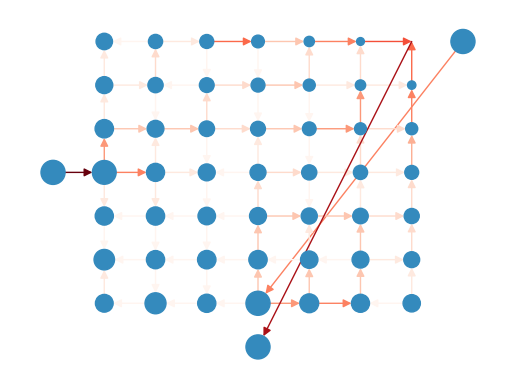

In [8]:
fig, ax = display_network_currents("scripts/2_funding_period/WP2/freq_double/uniform/data/net_currents_Nx=7_Ny=7_Nz=1_Ne=3.csv",
                            row=1, N_electrodes=3, arrow_scale=3, charge_landscape=True, node_size=300,
                            position_by_currents=False, pos=np_network_cubic.pos)

In [9]:
def display_landscape(path : str, row, Nx, Ny, fig=None, ax=None, cmap='coolwarm', vmin=None, vmax=None,
                        x_label='$x_{NP}$', y_label='$x_{NP}$'):

    arr = pd.read_csv(path).loc[row,:].values
    arr = arr.reshape(Nx, Ny)
    
    if fig == None:
        fig = plt.figure()
    if ax == None:
        ax = fig.add_subplot()
    
    ax.imshow(arr, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    return fig, ax